# Yield curve optimisation

In [1]:
# Load libraries
import numpy as np
import pandas as pd
import pandas_datareader.data as web
from matplotlib import pyplot
from pandas.plotting import scatter_matrix
import seaborn as sns
from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.neural_network import MLPRegressor

#Libraries for Deep Learning Models
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import SGD
from keras.layers import LSTM


#Libraries for Statistical Models
import statsmodels.api as sm

#Libraries for Saving the Model
from pickle import dump
from pickle import load

# Time series Models
from statsmodels.tsa.arima_model import ARIMA
#from statsmodels.tsa.statespace.sarimax import SARIMAX

# Error Metrics
from sklearn.metrics import mean_squared_error

# Feature Selection
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2, f_regression

#Plotting 
from pandas.plotting import scatter_matrix
from statsmodels.graphics.tsaplots import plot_acf

#Warning
import warnings
warnings.filterwarnings("ignore")

In [2]:
# Get the data by webscapping using pandas datareader
tsy_tickers = ['DGS1MO', 'DGS3MO', 'DGS1', 'DGS2', 'DGS5', 'DGS7', 'DGS10', 'DGS30',
               'TREAST', # -- U.S. Treasury securities held by the Federal Reserve ( Millions of Dollars )
               'FYGFDPUN', # -- Federal Debt Held by the Public ( Millions of Dollars )
               'FDHBFIN', # -- Federal Debt Held by Foreign and International Investors ( Billions of Dollars )
               'GFDEBTN', # -- Federal Debt: Total Public Debt ( Millions of Dollars )
               'BAA10Y', # -- Baa Corporate Bond Yield Relative to Yield on 10-Year
              ]
tsy_data = web.DataReader(tsy_tickers, 'fred').dropna(how='all').ffill()
tsy_data['FDHBFIN'] = tsy_data['FDHBFIN'] * 1000
tsy_data['GOV_PCT'] = tsy_data['TREAST'] / tsy_data['GFDEBTN']
tsy_data['HOM_PCT'] = tsy_data['FYGFDPUN'] / tsy_data['GFDEBTN']
tsy_data['FOR_PCT'] = tsy_data['FDHBFIN'] / tsy_data['GFDEBTN']

In [3]:
return_period = 5
#Y = tsy_data.loc[:, ['DGS1MO', 'DGS5', 'DGS30']].diff(return_period).shift(-return_period)
#return_period = 5
Y = tsy_data.loc[:, ['DGS1MO', 'DGS5', 'DGS30']].shift(-return_period)
Y.columns = [col+'_pred' for col in Y.columns]

#X = tsy_data.loc[:, ['DGS1MO', 'DGS3MO', 'DGS1', 'DGS2', 'DGS5', 'DGS7', 'DGS10', 'DGS30', 'GOV_PCT', 'HOM_PCT', 'FOR_PCT', 'BAA10Y']].diff(return_period)
X = tsy_data.loc[:, ['DGS1MO', 'DGS3MO', 'DGS1', 'DGS2', 'DGS5', 'DGS7', 'DGS10', 'DGS30', 'GOV_PCT', 'HOM_PCT', 'FOR_PCT', 'BAA10Y']]

dataset = pd.concat([Y, X], axis=1).dropna().iloc[::return_period, :]
Y = dataset.loc[:, Y.columns]
X = dataset.loc[:, X.columns]

In [4]:
dataset.head()

,DGS1MO_pred,DGS5_pred,DGS30_pred,DGS1MO,DGS3MO,DGS1,DGS2,DGS5,DGS7,DGS10,DGS30,GOV_PCT,HOM_PCT,FOR_PCT,BAA10Y
DATE,,,,,,,,,,,,,,,
2019-10-01,1.69,1.36,2.04,1.79,1.82,1.73,1.56,1.51,1.59,1.65,2.11,0.090843,0.740792,0.294991,2.22
2019-10-08,1.71,1.57,2.23,1.69,1.72,1.62,1.42,1.36,1.45,1.54,2.04,0.091250,0.740792,0.294991,2.30
2019-10-16,1.74,1.58,2.25,1.71,1.66,1.59,1.58,1.57,1.65,1.75,2.23,0.091507,0.740792,0.294991,2.22
2019-10-23,1.61,1.61,2.26,1.74,1.65,1.58,1.58,1.58,1.67,1.77,2.25,0.092632,0.740792,0.294991,2.18
2019-10-30,1.55,1.63,2.30,1.61,1.62,1.59,1.61,1.61,1.69,1.78,2.26,0.093766,0.740792,0.294991,2.17


In [5]:
dataset

,DGS1MO_pred,DGS5_pred,DGS30_pred,DGS1MO,DGS3MO,DGS1,DGS2,DGS5,DGS7,DGS10,DGS30,GOV_PCT,HOM_PCT,FOR_PCT,BAA10Y
DATE,,,,,,,,,,,,,,,
2019-10-01,1.69,1.36,2.04,1.79,1.82,1.73,1.56,1.51,1.59,1.65,2.11,0.090843,0.740792,0.294991,2.22
2019-10-08,1.71,1.57,2.23,1.69,1.72,1.62,1.42,1.36,1.45,1.54,2.04,0.091250,0.740792,0.294991,2.30
2019-10-16,1.74,1.58,2.25,1.71,1.66,1.59,1.58,1.57,1.65,1.75,2.23,0.091507,0.740792,0.294991,2.22
2019-10-23,1.61,1.61,2.26,1.74,1.65,1.58,1.58,1.58,1.67,1.77,2.25,0.092632,0.740792,0.294991,2.18
2019-10-30,1.55,1.63,2.30,1.61,1.62,1.59,1.61,1.61,1.69,1.78,2.26,0.093766,0.740792,0.294991,2.17
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-07-10,5.47,4.07,4.37,5.46,5.46,5.01,4.62,4.24,4.24,4.28,4.47,0.128319,0.796073,0.233958,1.56
2024-07-17,5.50,4.12,4.54,5.47,5.43,4.85,4.42,4.07,4.09,4.16,4.37,0.127898,0.796073,0.233958,1.56
2024-07-24,5.49,3.97,4.35,5.50,5.40,4.82,4.37,4.12,4.20,4.28,4.54,0.127903,0.796073,0.233958,1.65


In [6]:
dataset.shape

(246, 15)

<Axes: xlabel='DATE'>

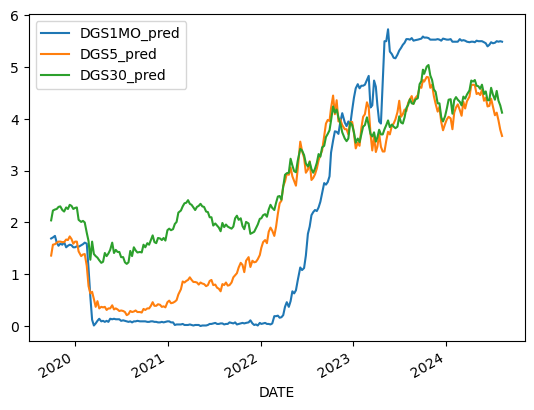

In [7]:
Y.plot()

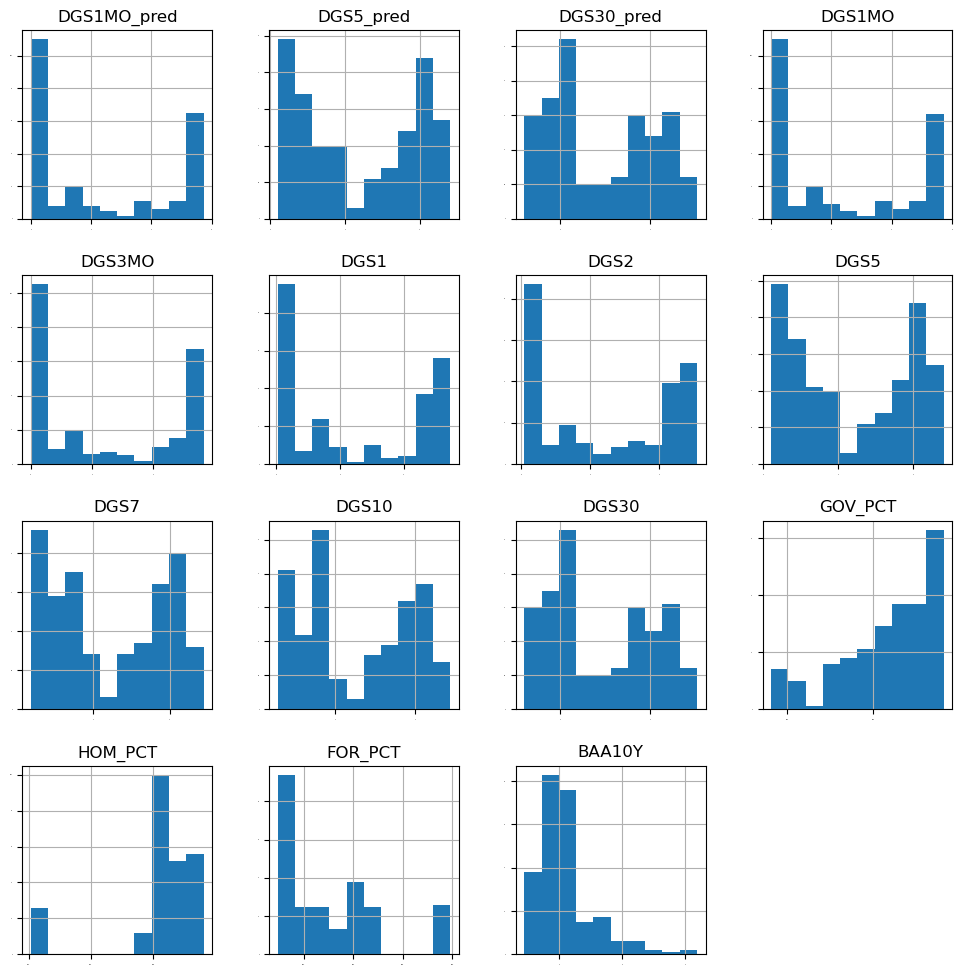

In [8]:
# histograms
dataset.hist(sharex=False, sharey=False, xlabelsize=1, ylabelsize=1, figsize=(12,12))
pyplot.show()

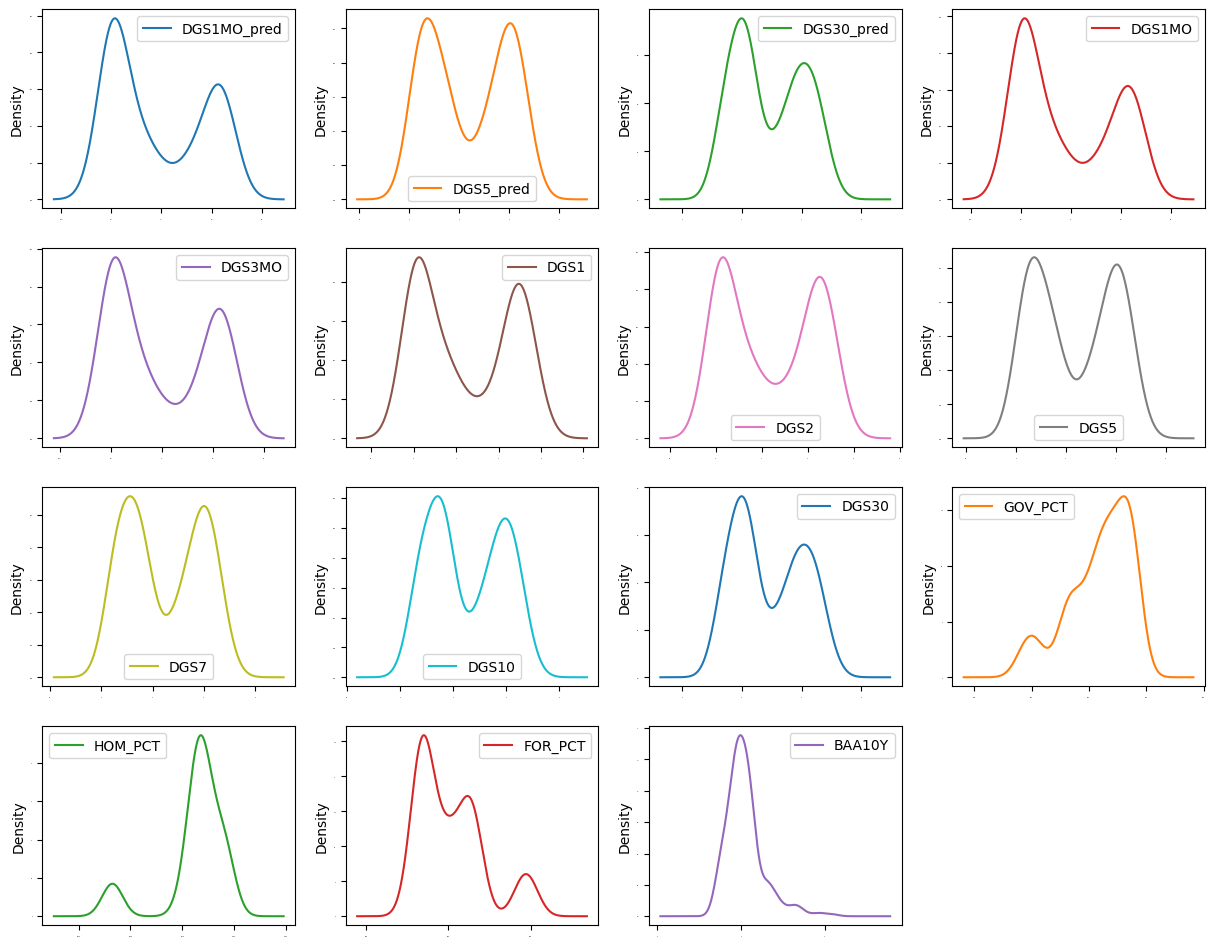

In [9]:
# density
dataset.plot(kind='density', subplots=True, layout=(5,4), sharex=False, legend=True, fontsize=1, figsize=(15,15))
pyplot.show()

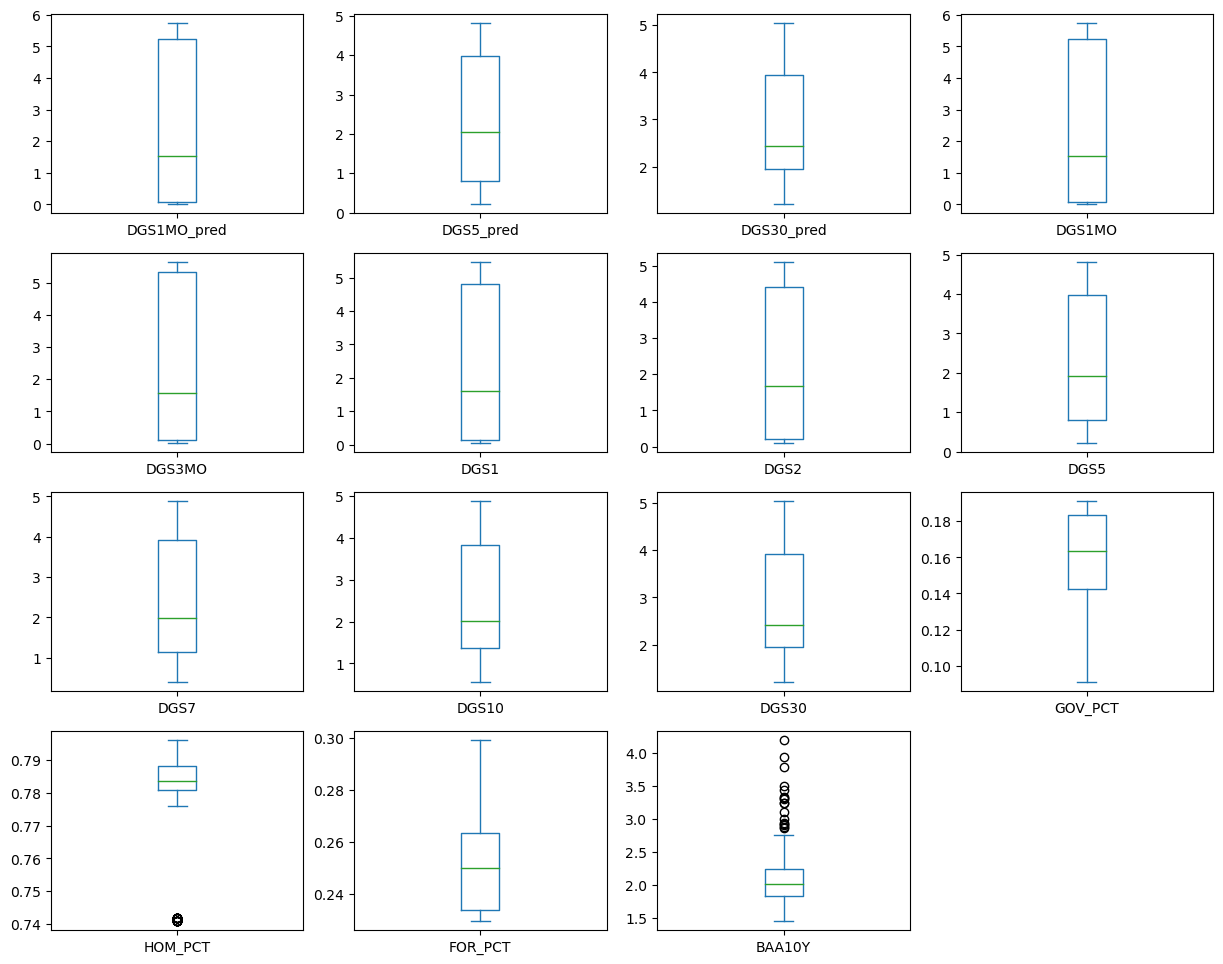

In [10]:
#Box and Whisker Plots
dataset.plot(kind='box', subplots=True, layout=(5,4), sharex=False, sharey=False, figsize=(15,15))
pyplot.show()

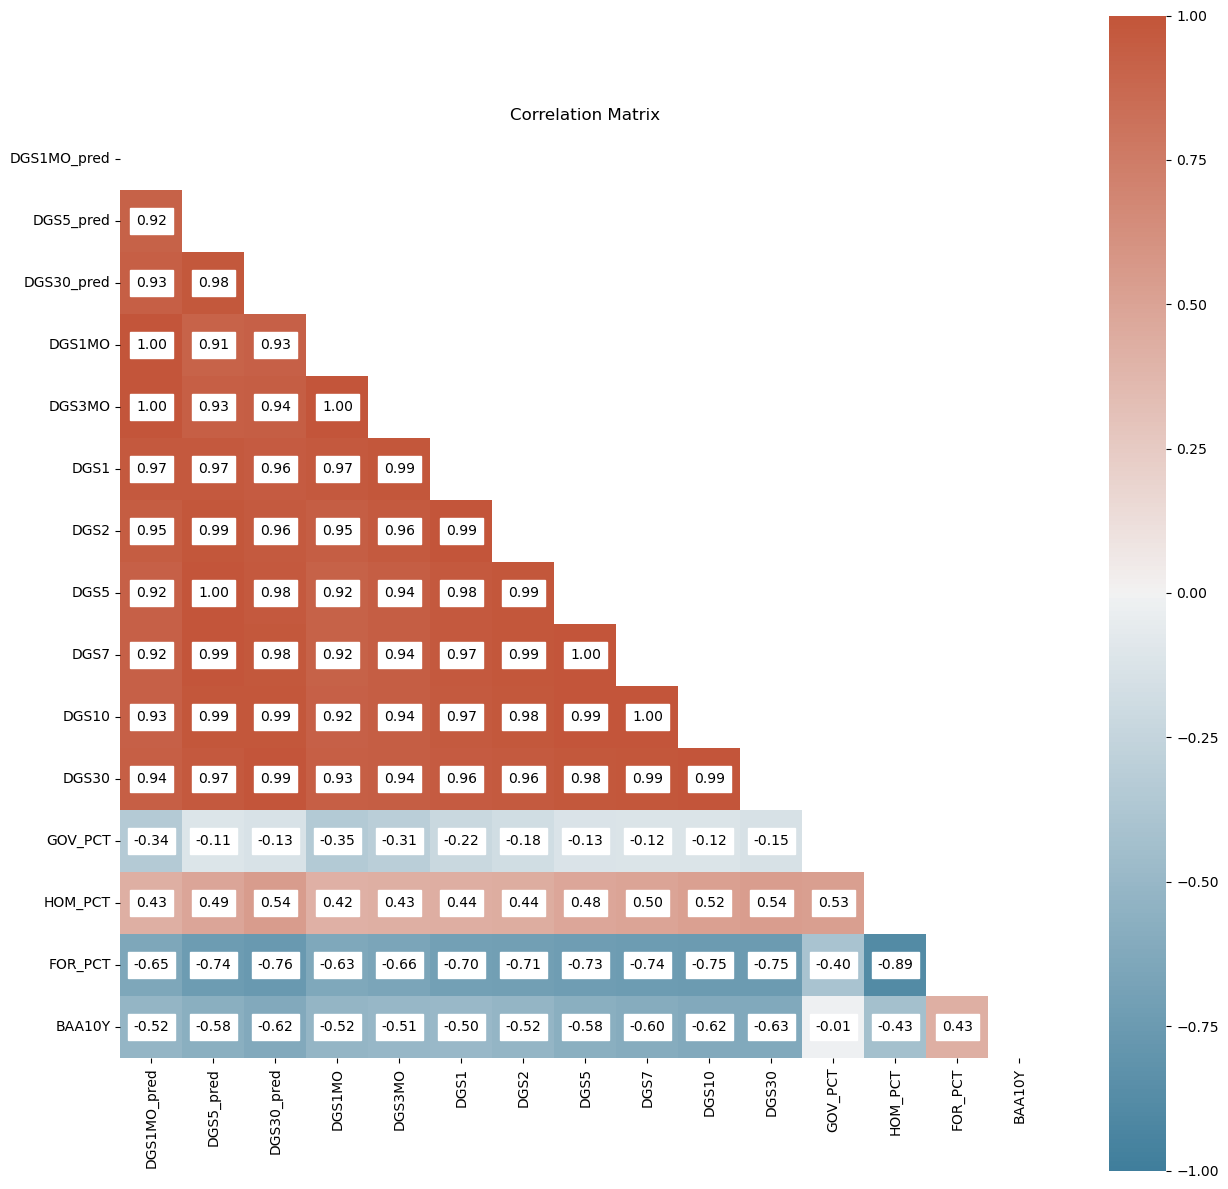

In [11]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming 'dataset' is your DataFrame
correlation = dataset.corr()

plt.figure(figsize=(15,15))
plt.title('Correlation Matrix')

# Generate a mask for the upper triangle (optional, to hide redundant values)
mask = np.triu(np.ones_like(correlation, dtype=bool))

# Choosing a diverging color map
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Create the heatmap with annotations and the mask
sns.heatmap(correlation, mask=mask, vmax=1, vmin=-1, square=True, annot=True, cmap=cmap, fmt=".2f", 
            annot_kws={'color':'black', 'backgroundcolor':'white'})
plt.show()


<Figure size 1500x1500 with 0 Axes>

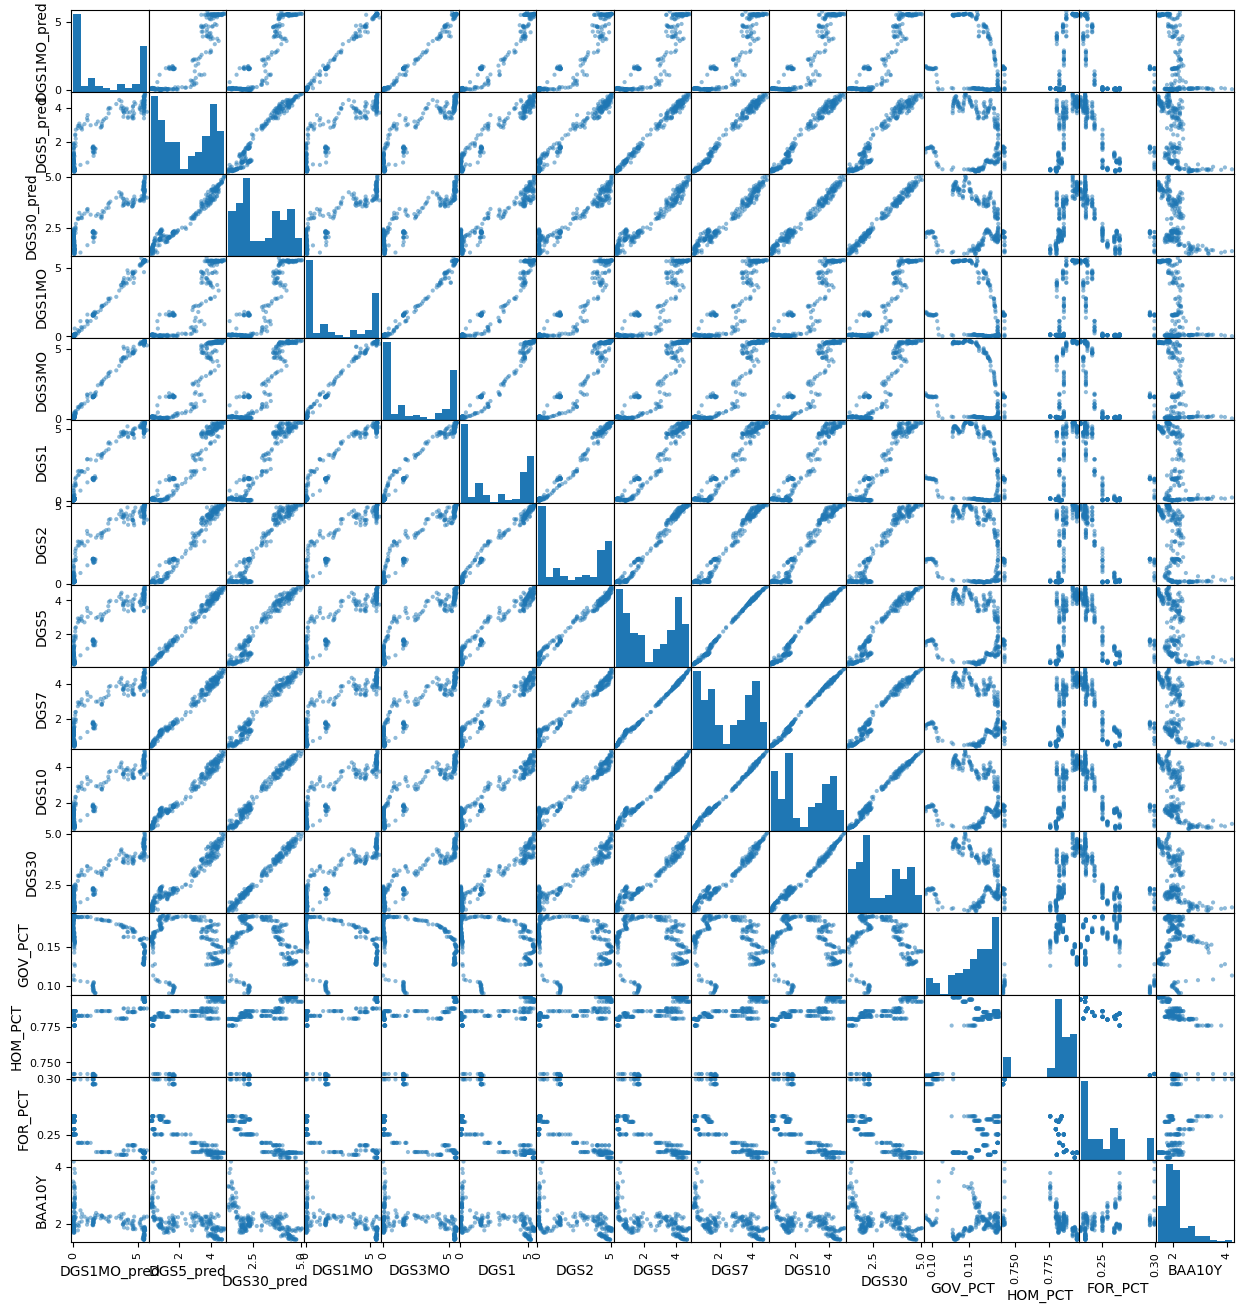

In [12]:
# Scatterplot Matrix
pyplot.figure(figsize=(15,15))
scatter_matrix(dataset,figsize=(15,16))
pyplot.show()

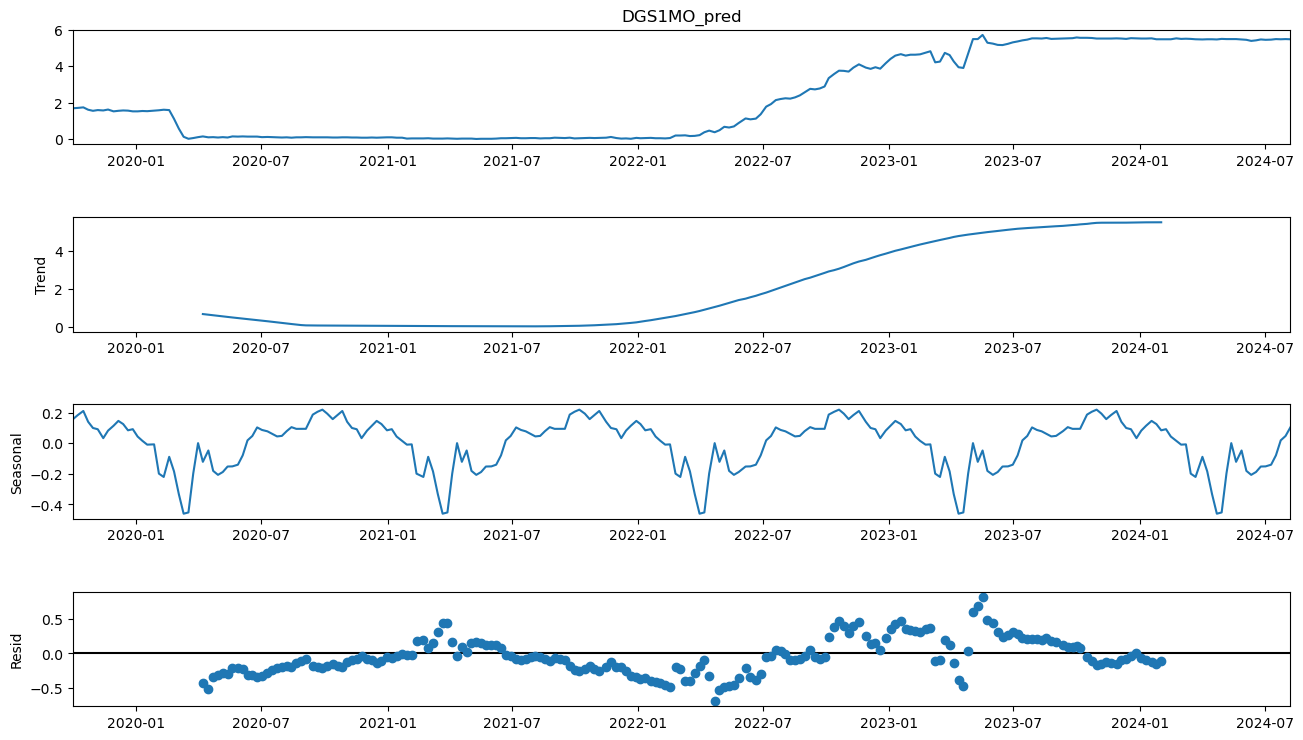

In [13]:
temp_Y = dataset['DGS1MO_pred']
res = sm.tsa.seasonal_decompose(temp_Y,period=52)
fig = res.plot()
fig.set_figheight(8)
fig.set_figwidth(15)
pyplot.show()

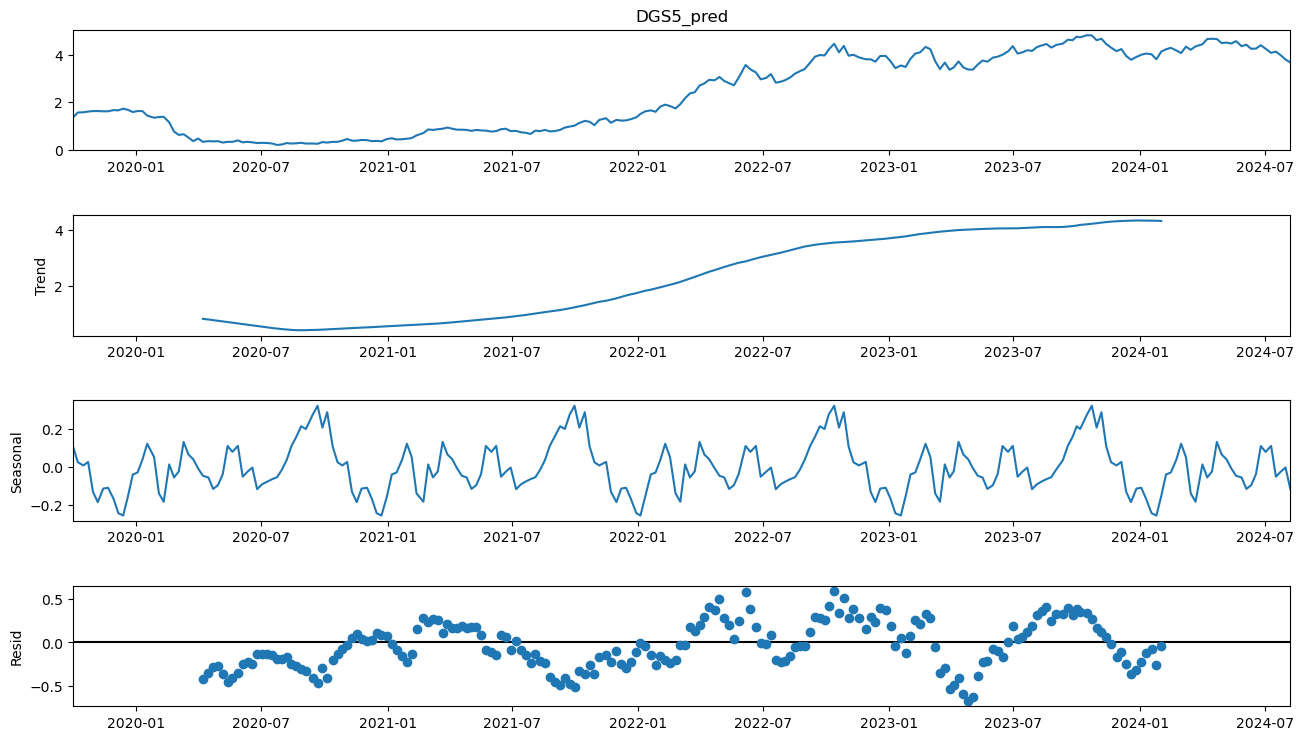

In [14]:
temp_Y = dataset['DGS5_pred']
res = sm.tsa.seasonal_decompose(temp_Y,period=52)
fig = res.plot()
fig.set_figheight(8)
fig.set_figwidth(15)
pyplot.show()

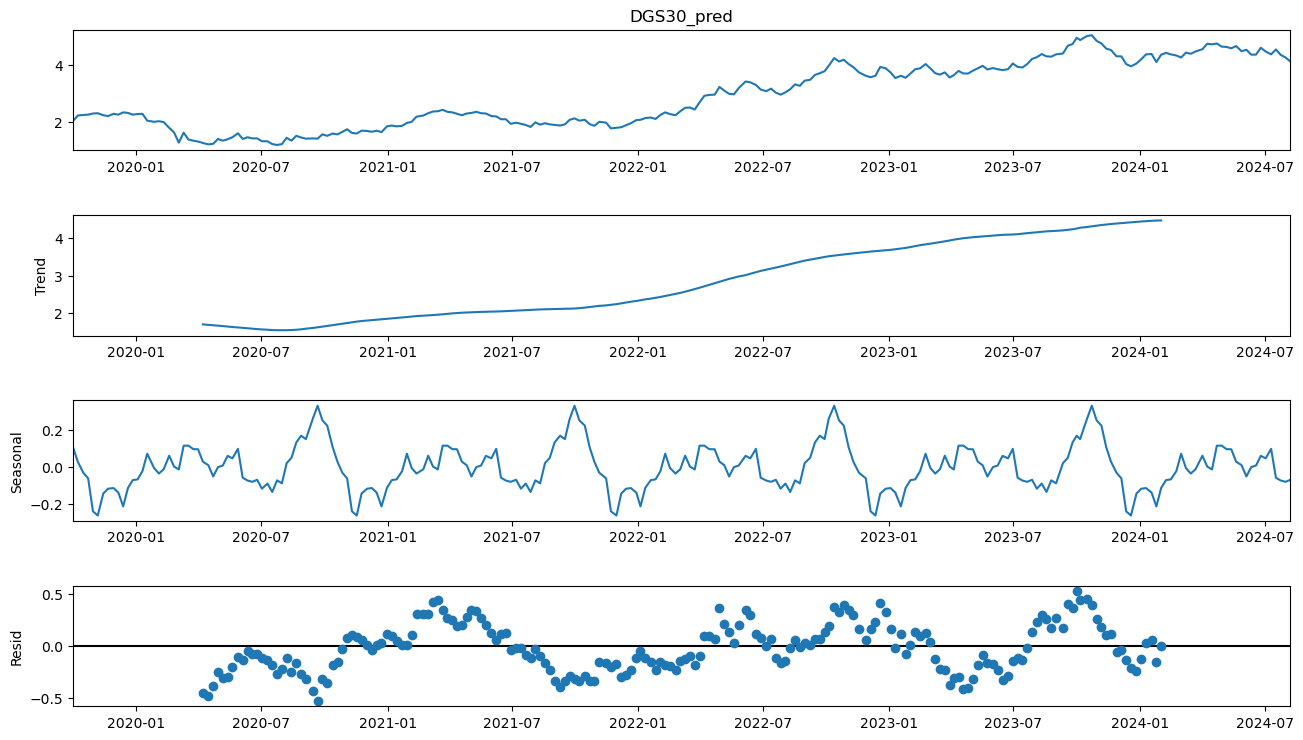

In [15]:
temp_Y = dataset['DGS30_pred']
res = sm.tsa.seasonal_decompose(temp_Y,period=52)
fig = res.plot()
fig.set_figheight(8)
fig.set_figwidth(15)
pyplot.show()

In [16]:
bestfeatures = SelectKBest(k=5, score_func=f_regression)
for col in Y.columns:
    temp_Y = dataset[col]
    temp_X = dataset.loc[:, X.columns]
    fit = bestfeatures.fit(temp_X,temp_Y)
    dfscores = pd.DataFrame(fit.scores_)
    dfcolumns = pd.DataFrame(X.columns)
    #concat two dataframes for better visualization 
    featureScores = pd.concat([dfcolumns,dfscores],axis=1)
    featureScores.columns = ['Specs','Score']  #naming the dataframe columns
    print(col)
    print(featureScores.nlargest(10,'Score'))  #print 10 best features
    print('--------------')

DGS1MO_pred
      Specs         Score
0    DGS1MO  73465.253633
1    DGS3MO  33615.063305
2      DGS1   4468.603489
3      DGS2   2218.831313
7     DGS30   1757.525349
6     DGS10   1496.149993
4      DGS5   1440.351549
5      DGS7   1430.530351
10  FOR_PCT    175.208258
11   BAA10Y     88.449718
--------------
DGS5_pred
      Specs         Score
4      DGS5  30348.476629
5      DGS7  20119.353904
6     DGS10  10359.539795
3      DGS2   9701.097744
7     DGS30   4382.062104
2      DGS1   4142.728810
1    DGS3MO   1676.986486
0    DGS1MO   1232.187753
10  FOR_PCT    295.456209
11   BAA10Y    121.987175
--------------
DGS30_pred
      Specs         Score
7     DGS30  22282.355490
6     DGS10  12954.221726
5      DGS7   7426.500363
4      DGS5   4890.024141
3      DGS2   3071.163331
2      DGS1   2627.303961
1    DGS3MO   1855.242102
0    DGS1MO   1516.084136
10  FOR_PCT    333.935720
11   BAA10Y    156.245953
--------------


In [17]:
# split out validation dataset for the end

validation_size = 0.2

#In case the data is not dependent on the time series, then train and test split randomly
seed = 7
X_train, X_validation, Y_train, Y_validation = train_test_split(X, Y, test_size=validation_size, random_state=seed)

In [18]:
# test options for regression
num_folds = 10
scoring = 'neg_mean_squared_error'

In [19]:
# spot check the algorithms
models = []
models.append(('LR', LinearRegression()))
models.append(('LASSO', Lasso()))
models.append(('EN', ElasticNet()))
models.append(('KNN', KNeighborsRegressor()))
models.append(('CART', DecisionTreeRegressor()))
#Neural Network
models.append(('MLP', MLPRegressor()))

In [20]:
kfold_results = []
names = []
validation_results = []
train_results = []
for name, model in models:
    kfold = KFold(n_splits=num_folds, random_state=seed, shuffle=True)
    #converted mean square error to positive. The lower the beter
    cv_results = -1* cross_val_score(model, X_train, Y_train, cv=kfold, scoring=scoring)
    kfold_results.append(cv_results)
    names.append(name)

    # Finally we Train on the full period and test against validation
    res = model.fit(X_train, Y_train)
    validation_result = np.mean(np.square(res.predict(X_validation) - Y_validation))
    validation_results.append(validation_result)
    train_result = np.mean(np.square(res.predict(X_train) - Y_train))
    train_results.append(train_result)
    
    msg = "%s: \nAverage CV error: %s \nStd CV Error: (%s) \nTraining Error:\n%s \nTest Error:\n%s" % \
    (name, str(cv_results.mean()), str(cv_results.std()), str(train_result), str(validation_result))
    print(msg)
    print('----------')

LR: 
Average CV error: 0.019434406180485857 
Std CV Error: (0.008054801779052113) 
Training Error:
DGS1MO_pred    0.013771
DGS5_pred      0.019898
DGS30_pred     0.011988
dtype: float64 
Test Error:
DGS1MO_pred    0.010919
DGS5_pred      0.012467
DGS30_pred     0.016617
dtype: float64
----------
LASSO: 
Average CV error: 0.301715403583879 
Std CV Error: (0.047157467884793004) 
Training Error:
DGS1MO_pred    0.198450
DGS5_pred      0.354118
DGS30_pred     0.340770
dtype: float64 
Test Error:
DGS1MO_pred    0.188762
DGS5_pred      0.327164
DGS30_pred     0.290744
dtype: float64
----------
EN: 
Average CV error: 0.16864539430129757 
Std CV Error: (0.0289580120687946) 
Training Error:
DGS1MO_pred    0.113983
DGS5_pred      0.198484
DGS30_pred     0.184552
dtype: float64 
Test Error:
DGS1MO_pred    0.096342
DGS5_pred      0.177584
DGS30_pred     0.144685
dtype: float64
----------
KNN: 
Average CV error: 0.02241056666666667 
Std CV Error: (0.010499792070061183) 
Training Error:
DGS1MO_pred  

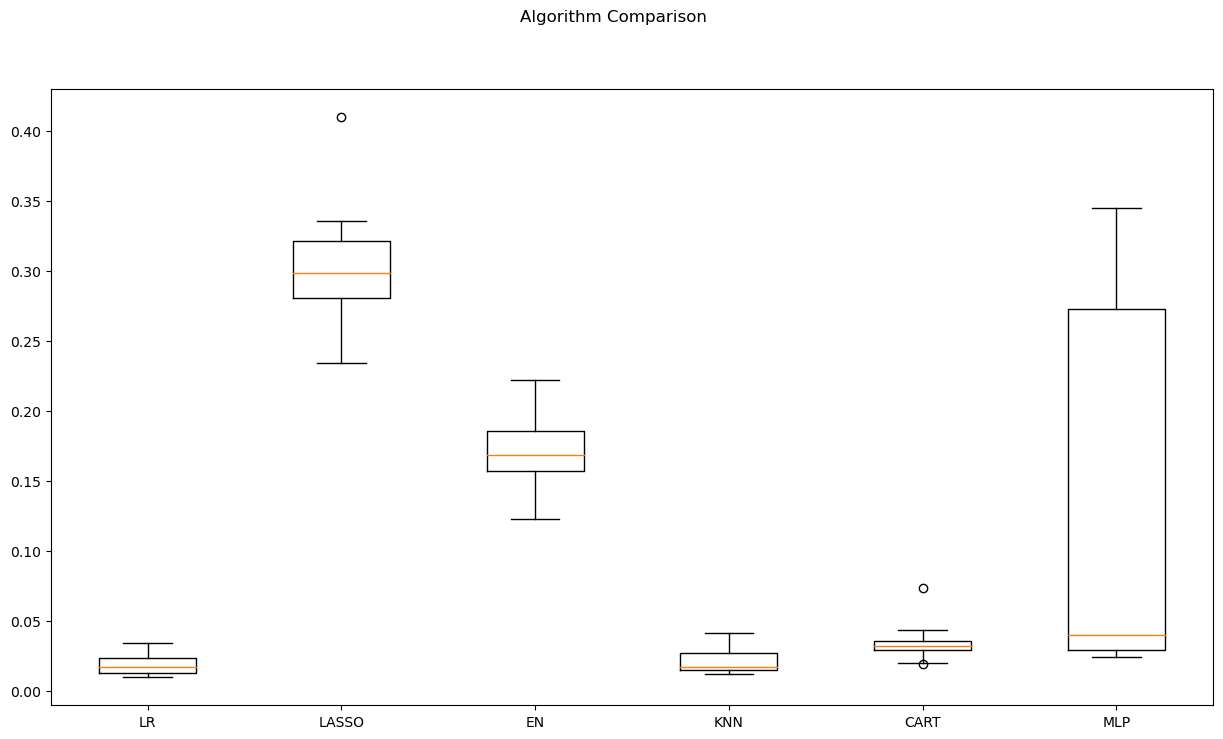

In [21]:
# compare algorithms
fig = pyplot.figure()
fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)
pyplot.boxplot(kfold_results)
ax.set_xticklabels(names)
fig.set_size_inches(15,8)
pyplot.show()

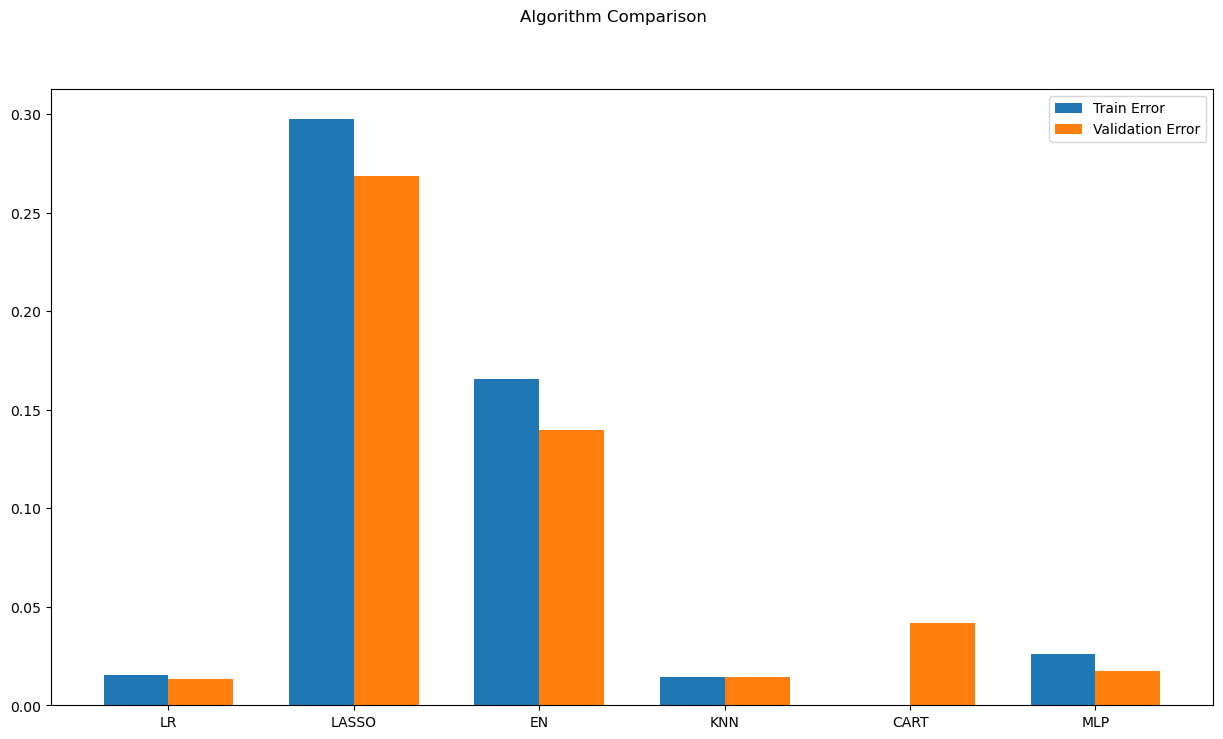

In [22]:
# compare algorithms
fig = pyplot.figure()

ind = np.arange(len(names))  # the x locations for the groups
width = 0.35  # the width of the bars

fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)
pyplot.bar(ind - width/2, [x.mean() for x in train_results],  width=width, label='Train Error')
pyplot.bar(ind + width/2, [x.mean() for x in validation_results], width=width, label='Validation Error')
fig.set_size_inches(15,8)
pyplot.legend()
ax.set_xticks(ind)
ax.set_xticklabels(names)
pyplot.show()

In [23]:
# 7. Grid search : MLPRegressor 
'''
hidden_layer_sizes : tuple, length = n_layers - 2, default (100,)
    The ith element represents the number of neurons in the ith
    hidden layer.
'''
param_grid={'hidden_layer_sizes': [(20,), (50,), (20,20), (20, 30, 20)]}
model = MLPRegressor()
kfold = KFold(n_splits=num_folds, random_state=seed, shuffle=True)
grid = GridSearchCV(estimator=model, param_grid=param_grid, scoring=scoring, cv=kfold)
grid_result = grid.fit(X_train, Y_train)
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: -0.065980 using {'hidden_layer_sizes': (20, 30, 20)}
-0.203787 (0.139274) with: {'hidden_layer_sizes': (20,)}
-0.074990 (0.061097) with: {'hidden_layer_sizes': (50,)}
-0.073208 (0.034450) with: {'hidden_layer_sizes': (20, 20)}
-0.065980 (0.063159) with: {'hidden_layer_sizes': (20, 30, 20)}


In [24]:
# prepare model
model = MLPRegressor(hidden_layer_sizes= (50,))
model.fit(X_train, Y_train)

MLPRegressor(hidden_layer_sizes=(50,))

In [25]:
# estimate accuracy on validation set
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
predictions = model.predict(X_validation)
mse_MLP = mean_squared_error(Y_validation, predictions)
r2_MLP = r2_score(Y_validation, predictions)

# prepare model
model_2 = LinearRegression()
model_2.fit(X_train, Y_train)
predictions_2 = model_2.predict(X_validation)

mse_OLS = mean_squared_error(Y_validation, predictions_2)
r2_OLS = r2_score(Y_validation, predictions_2)
print("MSE Regression = %f, MSE MLP = %f" % (mse_OLS, mse_MLP ))
print("R2 Regression = %f, R2 MLP = %f" % (r2_OLS, r2_MLP ))

MSE Regression = 0.013334, MSE MLP = 0.029642
R2 Regression = 0.992993, R2 MLP = 0.987439


In [26]:
train_size = int(len(X) * (1-validation_size))
X_train, X_validation = X[0:train_size], X[train_size:len(X)]
Y_train, Y_validation = Y[0:train_size], Y[train_size:len(X)]

modelMLP = MLPRegressor(hidden_layer_sizes= (50,))
modelOLS = LinearRegression()
model_MLP = modelMLP.fit(X_train, Y_train)
model_OLS = modelOLS.fit(X_train, Y_train)

Y_predMLP = pd.DataFrame(model_MLP.predict(X_validation), index=Y_validation.index,
                      columns=Y_validation.columns)

Y_predOLS = pd.DataFrame(model_OLS.predict(X_validation), index=Y_validation.index,
                      columns=Y_validation.columns)

<Axes: xlabel='DATE'>

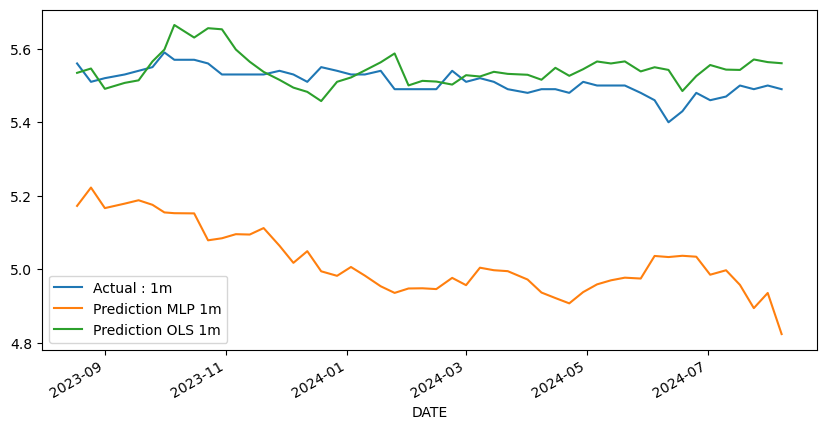

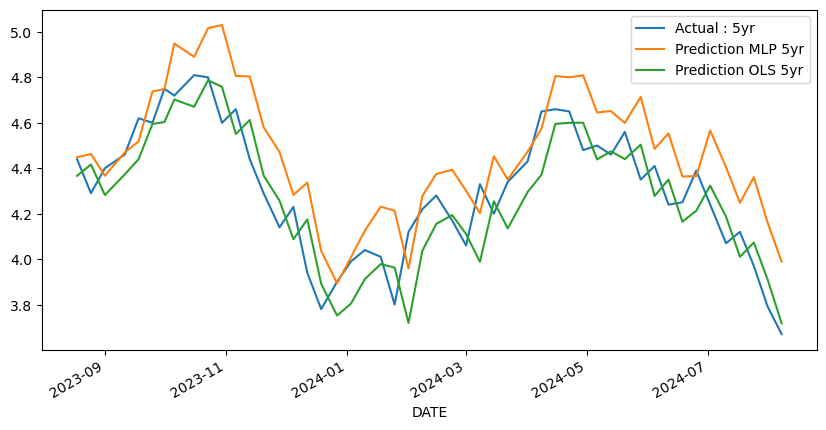

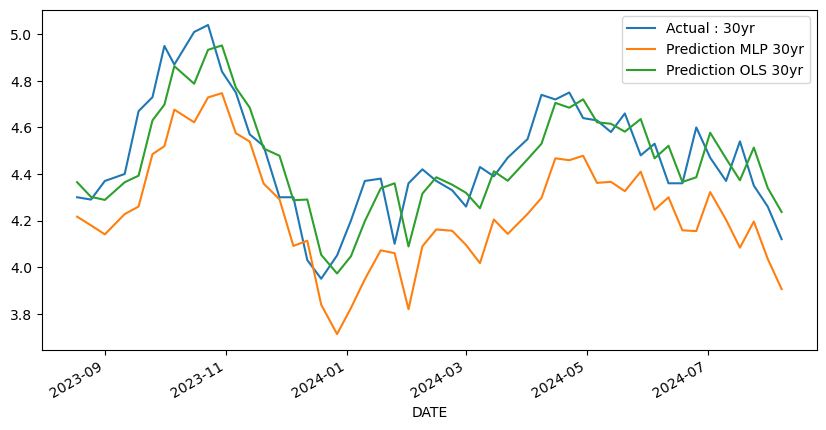

In [27]:
pd.DataFrame({'Actual : 1m': Y_validation.loc[:, 'DGS1MO_pred'],
              'Prediction MLP 1m': Y_predMLP.loc[:, 'DGS1MO_pred'],
              'Prediction OLS 1m': Y_predOLS.loc[:, 'DGS1MO_pred']}).plot(figsize=(10,5))

pd.DataFrame({'Actual : 5yr': Y_validation.loc[:, 'DGS5_pred'],
              'Prediction MLP 5yr': Y_predMLP.loc[:, 'DGS5_pred'],
              'Prediction OLS 5yr': Y_predOLS.loc[:, 'DGS5_pred']}).plot(figsize=(10,5))

pd.DataFrame({'Actual : 30yr': Y_validation.loc[:, 'DGS30_pred'],
              'Prediction MLP 30yr': Y_predMLP.loc[:, 'DGS30_pred'],
              'Prediction OLS 30yr': Y_predOLS.loc[:, 'DGS30_pred']}).plot(figsize=(10,5))